# 1

#### En el ejemplo de teoría hemos visto la forma de entrenar utilizando un trozo de datos como en la imagen "way1.png". 

(Básicamente, tener en cuenta más datos de entrenamiento [[20% de test]])

Investiga la forma de realizar el ejercicio a partir del gif "way3_sliding_window.gif":

- ¿Da mejores resultados entrenar el modelo así?

Algo muy típico en el trabajo de data scientist

![](../rnn/sliding_windows_google.png)

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [94]:
# Total time points
N = 3000
# Time point to partition train/test splits
Tp = 2500

t = np.arange(0,N)
x = (2*np.sin(0.02*t)*np.sin(0.003*t))+0.5*np.random.normal(size=N)
df = pd.DataFrame(x, columns=['Data'])
len(df)

3000

In [95]:
values = df.values
train, test = values[0:Tp ,:], values[Tp:N,:]

In [96]:
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (2500, 1)
Test data length: (500, 1)


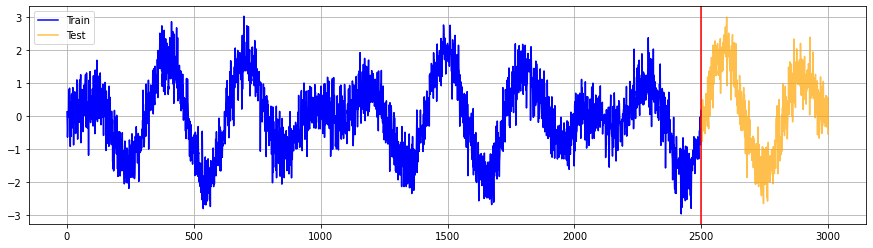

In [97]:
index = df.index.values
plt.figure(figsize=(15,4))
plt.plot(index[0:Tp],train,c='blue')
plt.plot(index[Tp:N],test,c='orange',alpha=0.7)
plt.legend(['Train','Test'])
plt.axvline(df.index[Tp], c="r")
plt.grid(True)
plt.show()

In [98]:
step = 4
np.append(train,np.repeat(train[-1,],step)).shape

(2504,)

In [99]:
test = np.append(test, np.repeat(test[-1,],step))
train = np.append(train, np.repeat(train[-1,],step))

In [100]:
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (2504,)
Test data length: (504,)


In [106]:
def convert_to_matrix(data, step):
    X, Y = [], []
    for i in range(len(data)-step):
        d = i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

In [107]:
# trainX = np.reshape(trainX, (750, 1, 4))
# Utilizamos el shape para que cualquier modificación de la variable step no tengamos que hacerla a mano
# Redimensionamos a: 
# - Tamaño total del conjunto train
# - Nº filas
# - Nº columnas
# (Tamaño total del conjunto train, Nº filas, Nº columnas)
trainX, trainY = convert_to_matrix(train,step)
testX, testY = convert_to_matrix(test,step)

print(trainX.shape)
print(trainY.shape)

(2500, 4)
(2500,)


In [103]:
#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [108]:
trainX.shape

(2500, 4)

In [109]:
window_length = 100

train_generator = TimeseriesGenerator(trainX,trainY, length=window_length, sampling_rate=1, batch_size=20)

test_generator = TimeseriesGenerator(trainX,trainY, length=window_length, sampling_rate=1, batch_size=20)

In [110]:
len(train_generator)

120

In [118]:
def build_simple_rnn(lr=0.001):
    """
    Builds and compiles a simple RNN model
    Arguments:
              num_units: Number of units of a the simple RNN layer
              embedding: Embedding length - Steps - Tamaño de ventana
              num_dense: Number of neurons in the dense layer followed by the RNN layer
              lr: Learning rate (uses RMSprop optimizer)
    Returns:
              A compiled Keras model.
    """
    model = Sequential()
    model.add(SimpleRNN(128, input_shape= (window_length,4), activation="relu"))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate=lr),metrics=['mse'])
    #model.compile(optimizer='adam', loss='mse')
    
    return model

In [119]:
model = build_simple_rnn()

In [120]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_9 (SimpleRNN)     (None, 128)               17024     
_________________________________________________________________
dense_16 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 21,185
Trainable params: 21,185
Non-trainable params: 0
_________________________________________________________________


In [124]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

In [128]:
num_epochs = 100

In [129]:
model.fit_generator(train_generator,validation_data= test_generator,epochs=num_epochs, steps_per_epoch=step)

Epoch 1/100
1/4 [======>.......................] - ETA: 0s - loss: 0.2695 - mse: 0.2695C:\Users\Adrià\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
4/4 [==============================] - 0s 145ms/step - loss: 0.2738 - mse: 0.2738 - val_loss: 0.2767 - val_mse: 0.2767
Epoch 2/100
4/4 [==============================] - 0s 150ms/step - loss: 0.2925 - mse: 0.2925 - val_loss: 0.2891 - val_mse: 0.2891
Epoch 3/100
4/4 [==============================] - 0s 135ms/step - loss: 0.2213 - mse: 0.2213 - val_loss: 0.2803 - val_mse: 0.2803
Epoch 4/100
4/4 [==============================] - 0s 131ms/step - loss: 0.2822 - mse: 0.2822 - val_loss: 0.3226 - val_mse: 0.3226
Epoch 5/100
4/4 [==============================] - 0s 133ms/step - loss: 0.3638 

In [130]:
model.evaluate_generator(test_generator, verbose=0)

C:\Users\Adrià\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.2915104925632477, 0.2915104925632477]

In [131]:
pred = model.predict_generator(test_generator)

C:\Users\Adrià\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [137]:
df_pred= pd.concat([pd.DataFrame(pred), pd.DataFrame(trainX[:,1:][window_length:])],axis=1)

In [138]:
df_pred.head()

,0,0,1,2
0,0.319824,0.586124,0.205302,-0.304336
1,0.291321,0.205302,-0.304336,1.222973
2,0.281784,-0.304336,1.222973,0.488269
3,0.040561,1.222973,0.488269,0.328828
4,0.212620,0.488269,0.328828,0.410666


<AxesSubplot:>

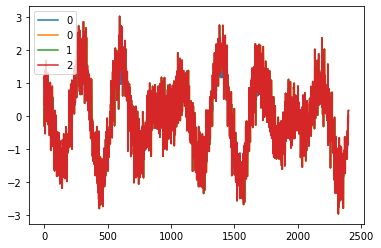

In [139]:
df_pred.plot()